In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys

from learningratefinder import LearningRateFinder
from minigooglenet import MiniGoogLeNet
from clr_callback import CyclicLR
import config

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

from keras.datasets import fashion_mnist
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [13]:
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

# Fashion MNIST images are 28x28 but the network we will be training expects 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])

# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float")/255.0
testY = testY.astype("float")/255.0

# reshape the data matrices to include channel dimension (required for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))

# convert the labels from integers to vectors
lb = LabelBinarizer()

[INFO] loading Fashion MNIST data...


In [14]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      horizontal_flip=True,
                                      fill_mode="nearest")

In [15]:
# initialize the optimizer model
print("[INFO] compiling model...")
opt = SGD(lr=config.MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [16]:
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
         1e-10, 1e+1,
         stepsPerEpoch=np.ceil((len(trainX) / float(config.BATCH_SIZE))),
         batchSize=config.BATCH_SIZE)

[INFO] finding learning rate...
Epoch 1/3
938/938 [==============================] - 8397s 9s/step - loss: 2.6045 - acc: 0.0992
Epoch 2/3
938/938 [==============================] - 8345s 9s/step - loss: 2.1199 - acc: 0.2568
Epoch 3/3
883/938 [===========================>..] - ETA: 8:08 - loss: 0.9808 - acc: 0.6797

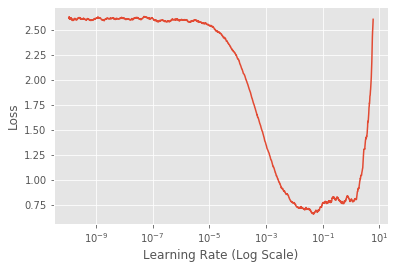

In [19]:
plt.style.use('ggplot')
lrf.plot_loss()
plt.savefig(config.LRFIND_PLOT_PATH)

* [1e-10, 1e-5]: loss does not decrease => learning rate is too small => network isn't learning
* [1e-5]: loss starts to decrease =>learning rate is just large enough => network can just start to learn
* [1e-4, 1e-3]: loss is decreasing rapidly => "sweet spot" => network can learn quickly
* [1e-2, ]: tiny increase in loss => learning rate is too large again => network isn't learning
* [1e-1]: large jump => learning rate is too large

Based on this plot, we should choose 1e-5 as our base learning rate and 1e-2 as our max learning rate — these values indicate a learning rate just small enough for our network to start to learn, along with a learning rate that this is large enough for our network to rapidly learn, but not so large that our loss explodes.

In [ ]:
# Update the MIN_LR and MAX_LR values in config.py and train the network on full dataset
'''stepSize = config.STEP_SIZE * (trainX.shape[0] // config.BATCH_SIZE)
clr = CyclicLR(
    mode=config.CLR_METHOD,
    base_lr=config.MIN_LR,
    max_lr=config.MAX_LR,
    step_size=stepSize)

print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
    epochs=config.NUM_EPOCHS,
    callbacks=[clr],
    verbose=1)

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=config.BATCH_SIZE)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=config.CLASSES))

N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(config.TRAINING_PLOT_PATH)

N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig(config.CLR_PLOT_PATH)'''